# Case Study Unit 8

#### Assignment
 - Pick a stock
  - Any stock
 - Get 4 years worth of data
 - Try and estimate the parameters p, d, q using techniques discussed for the stock data
 - Do a grid search for parameters
 - What is your final decision on parameters and WHY

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import quandl
import datetime
from statsmodels.tsa.arima_model import ARIMA

from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
# Pull down data
three_yrs_ago = datetime.date.today() - relativedelta(years=4)
start = three_yrs_ago
end = datetime.date.today()
 
stock = "TSLA"
tsla_all = quandl.get("WIKI/" + stock, start_date=start, end_date=end)
tsla = tsla_all["Adj. Close"]


In [3]:
# Create model and fit
model = ARIMA(tsla, order=(1,0,1))
model_fit = model.fit(disp=0)

/Users/kjprice/anaconda3/envs/python3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [4]:
# Create predictions
output = model_fit.predict()

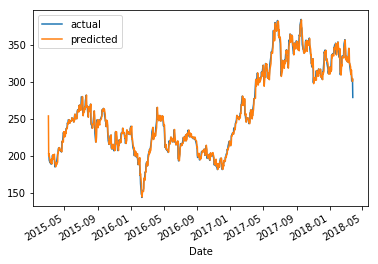

In [5]:
# Display prediction alongside actual
df = pd.DataFrame({'actual': tsla[1:], 'predicted': output})
df.plot()